# Compact

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.utils.tensorboard import SummaryWriter
import time

In [10]:
device = 'cpu'

In [11]:
class MyGraph:
    def __init__(self, width: int = 5, height: int = 5, max_edge: int = 5):
        self.width = width  # y-axis
        self.height = height  # x-axis
        # adj = np.eye(3)
        # adj = np.roll(adj, 1, axis=1)
        # adj = adj.T+adj
        # self.G = nx.generators.lattice.grid_2d_graph(
        #     self.height, self.width, create_using=nx.DiGraph
        # )
        # self.G = nx.DiGraph(nx.dense_gnm_random_graph(width, int(width*2)))
        self.G = nx.from_numpy_array(
            self.construct_random_subgraph(width, max_edges=max_edge),
            # adj,
            create_using=nx.DiGraph(),
        )
        self.adj_matrix = nx.adjacency_matrix(self.G).toarray()
        self.nodes_list = list(self.G.nodes.keys())
        self.edge_indices = self.calc_node_action_pairs()
        self.action_dim = None
        self.state_dim = None
        self.action_method = None
        self.state_method = None

    def construct_random_subgraph(self, num_nodes, min_edges=2, max_edges=5):
        min_edges -= 1
        max_edges -= 1
        connections = np.random.uniform(size=(num_nodes, num_nodes))
        connections += np.roll(
            np.eye(num_nodes), 1, 1
        )  # make sure every node is connected
        connections -= np.eye(num_nodes)  # make sure no self-connections
        # set strongest connections
        sorted_connections = np.sort(connections)[:, ::-1]
        min_edges = min_edges
        max_edges = max_edges + 1
        min_edges = int(min_edges / 2 + 0.5)  # used to be min_edges // 2
        max_edges = int(max_edges / 2 + 0.5)
        indices = np.stack(
            [np.arange(num_nodes), np.random.randint(min_edges, max_edges, num_nodes)]
        )
        thresholds = sorted_connections[indices[0], indices[1]]
        connections = np.where(connections > thresholds[:, None], 1.0, 0.0).astype(
            np.float32
        )
        connections = np.clip(connections + connections.T, 0, 1)
        return connections

    def calc_node_action_pairs(self) -> dict[(int, int) : int]:
        edge_indices = {}
        for edge_idx, edge in enumerate(self.G.edges()):
            # from_node, to_node = edge
            # from_node_idx = self.nodes_list.index(from_node)
            # to_node_idx = self.nodes_list.index(to_node)
            edge_indices[edge] = edge_idx
        return edge_indices

    def calc_action_between_cur_and_next_node(
        self, curr_node: int, next_node: int
    ) -> int:
        """
        each node has 4 actions: [S, N, W, E]
        """
        curr_x, curr_y = self.nodes_list[curr_node]
        next_x, next_y = self.nodes_list[next_node]
        origin_neighbors = [
            (curr_x + 1, curr_y),
            (curr_x - 1, curr_y),
            (curr_x, curr_y - 1),
            (curr_x, curr_y + 1),
        ]
        action = origin_neighbors.index((next_x, next_y))
        return action

    def random_walk(
        self, num_walks, walk_length, action_method: int = 0, state_method: int = 0
    ):
        """
        action_method:
            0: state-dependent action
            1: state-independent action (4 action)
        state_method:
            0: coordinate-independent state
            1: coordinate-dependent state (x, y)
        """
        self.action_method = action_method
        self.state_method = state_method
        if action_method == 0:  # state-dependent action
            self.action_dim = len(self.edge_indices)
        elif action_method == 1:  # state-independent action (4 action)
            self.action_dim = 4
        else:
            raise AttributeError
        if state_method == 0:  # coordinate-independent state
            self.state_dim = len(self.nodes_list)
        elif state_method == 1:  # coordinate-dependent state (x, y)
            self.state_dim = 2
        else:
            raise AttributeError
        dataset = []
        for _ in range(num_walks):
            curr_node = np.random.choice(len(self.nodes_list))
            for _ in range(walk_length):
                next_node = np.random.choice(
                    np.where(self.adj_matrix[curr_node] != 0)[0]
                ).item()
                action = self.action_node_to_emb(curr_node, next_node)
                curr_node_emb = self.state_int_to_emb(curr_node)
                next_node_emb = self.state_int_to_emb(next_node)
                dataset.append(np.concatenate([curr_node_emb, [action], next_node_emb]))
                curr_node = next_node
        return np.array(dataset)

    def state_int_to_emb(self, state: int) -> np.array:
        if self.state_method == 0:  # coordinate-independent state
            state_emb = np.zeros(self.state_dim)
            state_emb[state] = 1
        elif self.state_method == 1:  # coordinate-dependent state (x, y)
            state_emb = np.array(self.nodes_list[state])
        else:
            raise AttributeError
        return state_emb.astype(np.float32)

    def action_node_to_emb(self, curr_node: int, next_node: int) -> int:
        if self.action_method == 0:  # state-dependent action
            action = self.edge_indices[
                (self.nodes_list[curr_node], self.nodes_list[next_node])
            ]
        elif self.action_method == 1:  # state-independent action (4 action)
            action = self.calc_action_between_cur_and_next_node(curr_node, next_node)
        else:
            raise AttributeError
        return action

In [12]:
class GraphDataset(Dataset):
    def __init__(self, dataset, n_obs):
        self.from_node = (
            torch.from_numpy(dataset[:, :n_obs]).type(torch.float32).to(device)
        )
        self.to_node = (
            torch.from_numpy(dataset[:, n_obs + 1 :]).type(torch.float32).to(device)
        )
        self.action = torch.from_numpy(dataset[:, n_obs]).type(torch.int).to(device)

    def __getitem__(self, index):
        return self.from_node[index], self.action[index], self.to_node[index]

    def __len__(self):
        return len(self.from_node)

In [106]:
def CML_planner(graph: MyGraph, Q, V, start, goal, model):
    node_record = []
    curr = int(start)
    goal_node_emb = graph.state_int_to_emb(goal)
    for i in range(len(graph.nodes_list)):
        node_record.append(curr)
        if curr == goal:
            return i, node_record
        curr_node_emb = graph.state_int_to_emb(curr)
        delta = (
            Q @ goal_node_emb - Q @ curr_node_emb
        )  # TODO: start and goal are one-hot vector
        avail_nodes = np.where(graph.adj_matrix[curr] != 0)[0]  # int64
        # avail_actions = [
        #     graph.action_node_to_emb(curr, next_node) for next_node in avail_nodes
        # ]
        # if not model.use_nn:
        #     utility = delta.T @ V[:, avail_actions]
        # else:
        #     actions = torch.zeros((model.n_act, len(avail_actions)))
        #     for idx, edge in enumerate(avail_actions):
        #         actions[edge, idx] = 1
        #     utility = delta.T @ V(actions.T).numpy().T
        # eligibility = utility / graph.adj_matrix[curr][avail_nodes]
        # dtype = [("id", int), ("value", float)]
        # values = [(idx, value) for idx, value in enumerate(eligibility)]
        # a = np.array(values, dtype=dtype)
        # sorted_arr = np.sort(a, order="value")
        # sorted_arr = sorted_arr[::-1]  # reverse
        # for best_id, _ in sorted_arr:
        #     curr = int(avail_nodes[best_id])
        #     if curr not in node_record:
        #         break
        temp_max = -np.inf
        idx_max = -1
        for next_node in avail_nodes:
            if next_node not in node_record:
                action = graph.action_node_to_emb(curr, next_node)
                utility = delta.T @ V[:, action] / np.linalg.norm(V[:, action])
                if utility > temp_max:
                    temp_max = utility
                    idx_max = next_node
        if idx_max == -1:
            print("planning failed")
            raise ValueError
        curr = idx_max
    return i, node_record

In [14]:
class MyNNCML(nn.Module):
    def __init__(
        self,
        emb_dim,
        n_obs,
        n_act,
        Q_init_stddev,
        V_init_stddev,
        W_init_stddev,
        use_nn: bool = False,
        hidden=128,
    ):
        super().__init__()
        self.use_nn = use_nn
        self.n_act = n_act
        self.n_obs = n_obs
        self.Q = nn.Parameter(
            torch.randn(size=(emb_dim, n_obs)) * Q_init_stddev, requires_grad=True
        )

        if not self.use_nn:
            self.V = nn.Parameter(
                torch.randn(size=(emb_dim, n_act)) * V_init_stddev, requires_grad=True
            )
        else:
            self.V = nn.Sequential(
                nn.Linear(n_act, hidden, bias=False),
                # nn.BatchNorm1d(emb_dim, affine=False),
                nn.ReLU(),
                nn.Linear(hidden, emb_dim, bias=False),
                # nn.BatchNorm1d(emb_dim),
                # nn.Tanh(),
            )
        self.W = nn.Parameter(
            torch.randn(size=(n_act, emb_dim)) * W_init_stddev, requires_grad=True
        )

    def forward(self, data):
        nodes, action, next_nodes = data
        actions = torch.zeros((self.n_act, len(action))).to(device)
        for idx, edge in enumerate(action):
            actions[edge, idx] = 1
        if not self.use_nn:
            output = self.Q @ next_nodes.T - self.Q @ nodes.T - self.V @ actions
        else:
            action_emb = self.V(actions.T).T
            # output = self.Q @ (next_nodes - nodes).T - action_emb / torch.linalg.norm(action_emb, axis=1, keepdim=True)
            output = self.Q @ (next_nodes - nodes).T - action_emb
        # print(output.shape)
        return output

In [15]:
map_size = 5
my_graph = MyGraph(map_size, map_size, max_edge=5)
num_walks = 10
walk_length = map_size
dataset = my_graph.random_walk(num_walks, walk_length, 0, 0)
n_obs = my_graph.state_dim
n_act = my_graph.action_dim
print(n_obs, n_act)
dataset[0]

5 12


array([0., 0., 1., 0., 0., 6., 0., 0., 0., 1., 0.])

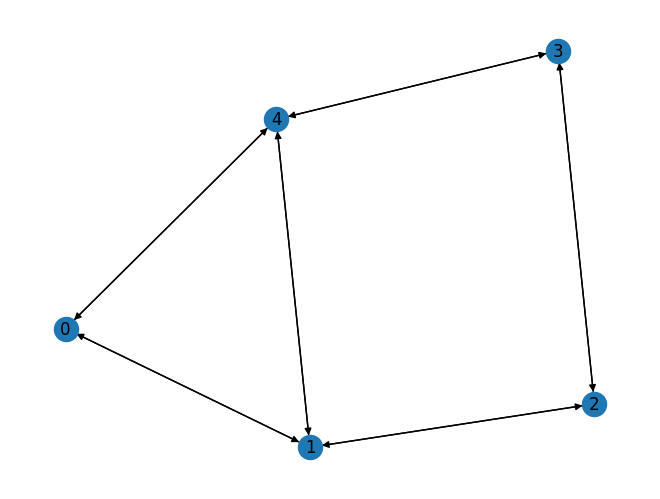

In [79]:
nx.draw(my_graph.G, with_labels=True)

# Con

In [ ]:
hiddens = reversed([512])
emb_dims = reversed([100])
bs = [50]

use_nn = False
Q_init_stddev = 0.1
V_init_stddev = 0.01
W_init_stddev = 0.01
eta_q = 0.1
eta_v = 0.01
eta_w = 0.01
num_epochs = 600
lr = 1e-4

dataset_torch = GraphDataset(dataset, n_obs)
graph = nx.from_numpy_array(
    my_graph.adj_matrix, create_using=nx.DiGraph()
)  # node_id is int, or else dijkstra will fail

for hidden in hiddens:
    for emb_dim in emb_dims:
        for batch_size in bs:
            loader = DataLoader(dataset_torch, shuffle=True, batch_size=batch_size)
            model = MyNNCML(
                emb_dim,
                n_obs,
                n_act,
                Q_init_stddev,
                V_init_stddev,
                W_init_stddev,
                use_nn=use_nn,
                hidden=hidden,
            )
            loss = nn.MSELoss()
            if not model.use_nn:
                optim = torch.optim.Adam(
                    params=[
                        {"params": model.Q, "lr": lr * 10},
                        {"params": model.V, "lr": lr},
                        {"params": model.W, "lr": lr},
                    ],
                    lr=0.01,
                )
            else:
                optim = torch.optim.AdamW(
                    params=[
                        {"params": model.Q, "lr": lr * 10},
                        {"params": model.V.parameters(), "lr": lr},
                        {"params": model.W, "lr": lr},
                    ],
                    lr=lr,
                    # weight_decay=1e-6
                )
            writer = SummaryWriter(
                f"""state_only/{time.time()}-{"nnCML" if use_nn else "CML"}-{str(map_size)}-{str(hidden) if use_nn else "0"}-{str(emb_dim)}-{str(batch_size)}-{lr}-Qnorm"""
            )
            global_step = 0

            model.to(device)
            for epoch in range(num_epochs):
                for i, data in enumerate(loader):
                    # print(i)
                    optim.zero_grad()
                    output = model(data)
                    l = loss(output, torch.zeros_like(output))
                    # l += (
                    #     torch.linalg.matrix_norm(
                    #         model.Q.T @ model.Q - torch.eye(model.n_obs).to(device)
                    #     )
                    #     * 0.005
                    # )
                    l.backward()
                    optim.step()
                    global_step += 1
                    with torch.no_grad():
                        #     # if not model.use_nn:
                        model.Q /= torch.linalg.norm(model.Q, axis=0)
                    writer.add_scalar("train loss", l.detach().item(), global_step)

            model.cpu()
            model.eval()
            if not model.use_nn:
                Q, V = model.Q.detach().numpy(), model.V.detach().numpy()
            else:
                Q = model.Q.detach().numpy()
                V = model.V.cpu()

            with torch.no_grad():
                N_goal = 1
                cml_distance = []
                cml_succ = 0
                dijkstra_distance = []
                for process in range(N_goal):
                    print(process)
                    start = np.random.randint(low=0, high=my_graph.adj_matrix.shape[0])
                    goal = np.random.randint(low=0, high=my_graph.adj_matrix.shape[0])
                    print(start, goal)

                    steps, o_record = CML_planner(my_graph, Q, V, start, goal, model)
                    print("CML done")
                    dijkstra_path = nx.shortest_path(
                        graph, source=start, target=goal, weight="weight"
                    )
                    print("Dji Done")
                    dijkstra_steps = len(dijkstra_path) - 1

                    dijkstra_distance.append(dijkstra_steps)
                    if o_record[-1] == goal:
                        cml_distance.append(steps)
                        cml_succ += 1
                    writer.add_scalar("CML AL", steps)
                    writer.add_scalar("dijkstra AL", dijkstra_steps)

            print(np.mean(cml_distance), np.mean(dijkstra_distance), cml_succ / N_goal)
            writer.add_text(
                "result",
                f"""{"nnCML" if use_nn else "CML"}, \n map_size: {str(map_size)}, n_obs: {n_obs}, n_act: {n_act}, \n hidden: {str(hidden) if use_nn else "0"}, embed: {str(emb_dim)}, BS: {str(batch_size)}, \n CML_AL: {np.mean(cml_distance)}, dj_AL: {np.mean(dijkstra_distance)}, SR: {cml_succ / N_goal}""",
            )

# Dis

In [126]:
n_obs = my_graph.state_dim
n_act = my_graph.action_dim
emb_dim = 1000
hidden = 10
use_nn = False
Q_init_stddev = 0.1
V_init_stddev = 0.01
W_init_stddev = 0.01
eta_q = 0.01
num_epochs = 10
batch_size = 50
dataset_torch = GraphDataset(dataset, n_obs)
n_obs, n_act

(5, 12)

In [127]:
loader = DataLoader(dataset_torch, shuffle=True, batch_size=batch_size)
model = MyNNCML(
    emb_dim,
    n_obs,
    n_act,
    Q_init_stddev,
    V_init_stddev,
    W_init_stddev,
    use_nn=use_nn,
    hidden=hidden,
)
loss = nn.MSELoss()
if not model.use_nn:
    optim = torch.optim.Adam(
        params=[
            {"params": model.Q, "lr": eta_q},
            {"params": model.V, "lr": eta_q / 10},
            {"params": model.W, "lr": eta_q / 10},
        ],
        lr=0.01,
    )
else:
    optim = torch.optim.Adam(
        params=[
            {"params": model.Q, "lr": eta_q / batch_size},
            {"params": model.V.parameters(), "lr": eta_v / batch_size},
            {"params": model.W, "lr": eta_w / batch_size},
        ],
        lr=0.01,
    )
mses1 = []
writer = SummaryWriter(
    f"""state_only/{"nnCML" if use_nn else "CML"}-{str(map_size)}-{str(hidden) if use_nn else "0"}-{str(emb_dim)}-{str(batch_size)}-{int(time.time())}"""
)
global_step = 0

In [130]:
model.to(device)
for epoch in range(500):
    for i, data in enumerate(loader):
        # print(i)
        optim.zero_grad()
        output = model(data)
        l = loss(output, torch.zeros_like(output))
        # l += (
        #     torch.linalg.matrix_norm(
        #         model.Q.T @ model.Q - torch.eye(model.n_obs).to(device)
        #     )
        #     * 0.005
        # )
        l.backward()
        optim.step()
        global_step += 1
        with torch.no_grad():
                # if not model.use_nn:
            model.V /= torch.linalg.norm(model.V, axis=0)
        # mses1.append(l.detach().mean().item())
        writer.add_scalar("train loss", l.detach().item(), global_step)

In [131]:
model.cpu()
if not model.use_nn:
    Q, V = model.Q.detach().numpy(), model.V.detach().numpy()
else:
    model.eval()
    Q = model.Q.detach().numpy()
    V = model.V.cpu()

In [132]:
with torch.no_grad():
    N_goal = 2000
    cml_distance = []
    cml_succ = 0
    dijkstra_distance = []
    graph = nx.from_numpy_array(
        my_graph.adj_matrix, create_using=nx.DiGraph()
    )  # node_id is int, or else dijkstra will fail
    # for process in range(N_goal):
    for start in range(my_graph.adj_matrix.shape[0]):
        for goal in range(my_graph.adj_matrix.shape[0]):
            # print(process)
            # start = np.random.randint(low=0, high=my_graph.adj_matrix.shape[0])
            # goal = np.random.randint(low=0, high=my_graph.adj_matrix.shape[0])
            # print(start, goal)

            steps, o_record = CML_planner(my_graph, Q, V, start, goal, model)

            dijkstra_path = nx.shortest_path(
                graph, source=start, target=goal, weight="weight"
            )
            dijkstra_steps = len(dijkstra_path) - 1

            dijkstra_distance.append(dijkstra_steps)
            if o_record[-1] == goal:
                cml_distance.append(steps)
                cml_succ += 1
            if dijkstra_steps < steps:
                print(o_record, dijkstra_path)
            # print(steps, dijkstra_steps)
        # print(np.mean(cml_distance))

    print(np.mean(cml_distance), np.mean(dijkstra_distance), cml_succ)

1.12 1.12 25


In [23]:
print(np.mean(cml_distance), np.mean(dijkstra_distance), cml_succ / N_goal)
writer.add_text(
    "result",
    f"""{"nnCML" if use_nn else "CML"}, \n map_size: {str(map_size)}, n_obs: {n_obs}, n_act: {n_act}, \n hidden: {str(hidden) if use_nn else "0"}, embed: {str(emb_dim)}, BS: {str(batch_size)}, \n **CML_AL**: {np.mean(cml_distance)}, **dj_AL**: {np.mean(dijkstra_distance)}, **SR**: {cml_succ / N_goal}""",
)

3.1655 2.98 1.0


In [26]:
edges = []
for src, tgt in my_graph.edge_indices:
    if tgt > src:
        temp = np.zeros(n_obs)
        temp[src] = -1
        temp[tgt] = 1
        edges.append(temp.copy())
edges = np.array(edges)
edge_emb_norm = Q @ edges.T / np.linalg.norm(Q @ edges.T, axis=0, keepdims=True)

In [71]:
gram_matrix = edge_emb_norm.T @ edge_emb_norm
iden_matrix = np.eye(gram_matrix.shape[0])
loss = (
    np.linalg.norm(gram_matrix - iden_matrix, ord="fro") ** 2
    / gram_matrix.shape[0]
    / (gram_matrix.shape[0] - 1)
)
loss

np.float64(0.10651566754487267)

In [22]:
np.linalg.matrix_norm(Q)

np.float32(6.7875714)

In [28]:
steps, o_record = CML_planner(my_graph, Q, V, 0, 2, model)
steps, o_record

(2, [0, np.int64(1), np.int64(2)])

In [30]:
np.set_printoptions(precision=2, linewidth=200)

In [110]:
V = V / np.linalg.norm(V, axis=0)

In [134]:
(V.T@V)

array([[ 1.  ,  0.5 , -1.  , -0.15, -0.5 ,  0.15, -0.18,  0.18, -0.17, -0.5 ,  0.5 ,  0.17],
       [ 0.5 ,  1.  , -0.5 ,  0.15,  0.5 , -0.15,  0.14, -0.14,  0.21, -1.  , -0.5 , -0.21],
       [-1.  , -0.5 ,  1.  ,  0.15,  0.5 , -0.15,  0.18, -0.18,  0.17,  0.5 , -0.5 , -0.17],
       [-0.15,  0.15,  0.15,  1.  ,  0.3 , -1.  , -0.38,  0.38, -0.32, -0.15, -0.3 ,  0.32],
       [-0.5 ,  0.5 ,  0.5 ,  0.3 ,  1.  , -0.3 ,  0.32, -0.32,  0.38, -0.5 , -1.  , -0.38],
       [ 0.15, -0.15, -0.15, -1.  , -0.3 ,  1.  ,  0.38, -0.38,  0.32,  0.15,  0.3 , -0.32],
       [-0.18,  0.14,  0.18, -0.38,  0.32,  0.38,  1.  , -1.  , -0.3 , -0.14, -0.32,  0.3 ],
       [ 0.18, -0.14, -0.18,  0.38, -0.32, -0.38, -1.  ,  1.  ,  0.3 ,  0.14,  0.32, -0.3 ],
       [-0.17,  0.21,  0.17, -0.32,  0.38,  0.32, -0.3 ,  0.3 ,  1.  , -0.21, -0.38, -1.  ],
       [-0.5 , -1.  ,  0.5 , -0.15, -0.5 ,  0.15, -0.14,  0.14, -0.21,  1.  ,  0.5 ,  0.21],
       [ 0.5 , -0.5 , -0.5 , -0.3 , -1.  ,  0.3 , -0.32,  0.32, -0.38,

<Axes: >

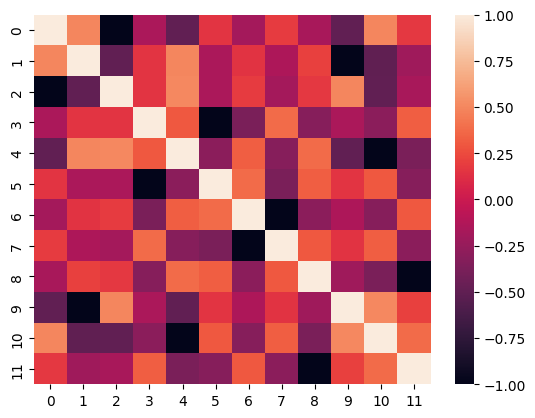

In [135]:
import seaborn as sns
sns.heatmap(V.T@V)


In [125]:
my_graph.G.edges


OutEdgeView([(0, 1), (0, 4), (1, 0), (1, 2), (1, 4), (2, 1), (2, 3), (3, 2), (3, 4), (4, 0), (4, 1), (4, 3)])

In [112]:
(Q @ my_graph.state_int_to_emb(4) - Q @ my_graph.state_int_to_emb(1)).T @ V[:, my_graph.action_node_to_emb(1, 4)]

np.float32(0.03977567)

In [113]:
(Q @ my_graph.state_int_to_emb(4) - Q @ my_graph.state_int_to_emb(0)).T @ V[:, my_graph.action_node_to_emb(1, 0)]

np.float32(-0.0041587716)

In [114]:
(Q @ my_graph.state_int_to_emb(4) - Q @ my_graph.state_int_to_emb(2)).T @ V[:, my_graph.action_node_to_emb(1, 2)]

np.float32(-0.007728895)

In [115]:
(Q @ my_graph.state_int_to_emb(1) - Q @ my_graph.state_int_to_emb(2)).T @ V[:, my_graph.action_node_to_emb(4, 1)]

np.float32(0.020814767)

In [36]:
trans_matri = np.zeros((n_obs, n_act))
edge_list = list(my_graph.G.edges.data())
for i in range(n_act):
    trans_matri[edge_list[i][0], i] = -1
    trans_matri[edge_list[i][1], i] = 1
trans_matri

array([[-1., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 1.,  0., -1., -1., -1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  0., -1., -1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -1., -1.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1., -1., -1., -1.]])

In [37]:
np.linalg.norm(Q@trans_matri - V)

np.float64(0.0019096165710126543)

In [54]:
np.linalg.eig(Q.T@Q)

EigResult(eigenvalues=array([11.814,  0.5  ,  0.5  ], dtype=float32), eigenvectors=array([[ 0.576,  0.73 ,  0.369],
       [ 0.581, -0.048, -0.813],
       [ 0.576, -0.682,  0.451]], dtype=float32))